# Laboratorio 5


*   Roberto Fernández
*   Vicente Sepúlveda
*   Nicolás Seura




1. Se instala una libreria para visualizacion de imágenes y la libreria que contiene la base de datos



In [1]:
!pip install Pillow
!pip install kaggle


2. Se descarga la base de datos de las piezas de ajedrez desde la pagina oficial.



In [2]:
!kaggle datasets download -d niteshfre/chessman-image-dataset


Dataset URL: https://www.kaggle.com/datasets/niteshfre/chessman-image-dataset
License(s): other
chessman-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


3. Se importan las librerias necesarias para manejo de datos, conjuntos de entrenamiento, generación de gráficos, etc.

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut, KFold
from sklearn.datasets import load_iris, load_files
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import os.path
import kagglehub
from pathlib import Path
from PIL import Image
import tensorflow as tf
import zipfile
import os

4. Posteriormente, se extraen los archivos y se preprocesan las imágenes, redimensionandolas y cargándolas por lote para mejorar la eficiencia, como ejemplo, se muestran 9 imágenes al azar de la base de datos para tener una noción sobre el estudio, posterior a eso, se crea una funcion que carga las imágenes preprocesadas y las normaliza, para posteriormente agregarlas a una lista en conjunto con las etiquetas. Finalmente, se transforman las etiquetas categóricas a numéricas.

Archivos extraídos en: chessman_dataset
Found 552 files belonging to 1 classes.
(32, 224, 224, 3) (32,)


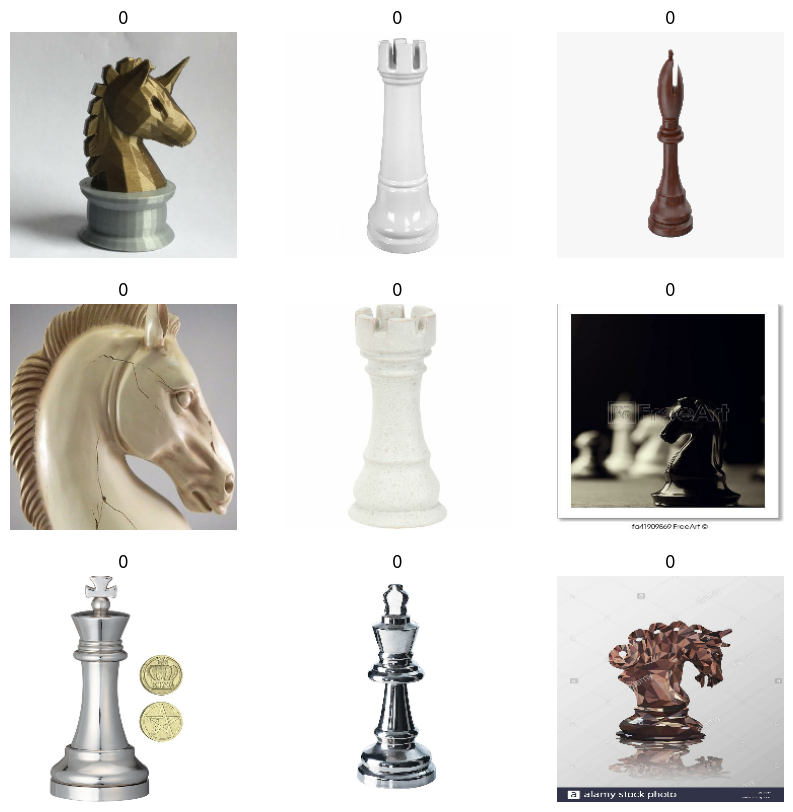

Total imágenes: 556, Dimensiones: 150528
Etiquetas codificadas: ['Bishop' 'King' 'Knight' 'Pawn' 'Queen' 'Rook']


In [4]:
# Ruta al archivo descargado
zip_path = "chessman-image-dataset.zip"
extract_to = "chessman_dataset"

# Extraer el contenido
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Archivos extraídos en: {extract_to}")

# Ruta a los datos extraídos
data_dir = "chessman_dataset"

# Cargar imágenes como dataset de TensorFlow
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(224, 224),  # Redimensionar imágenes (si es necesario)
    batch_size=32          # Tamaño del lote
)

# Mostrar la estructura del dataset
for images, labels in dataset.take(1):
    print(images.shape, labels.shape)
for images, labels in dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy())
        plt.axis("off")
    plt.show()
data_dir = "chessman_dataset/Chessman-image-dataset/Chess"  # Ruta a las imágenes
image_size = (224,224)  # Tamaño para redimensionar las imágenes

# 2. Cargar imágenes y etiquetas
def load_images(data_dir, image_size):
    images = []
    labels = []
    for class_name in os.listdir(data_dir):  # Cada carpeta es una clase
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                try:
                    img = load_img(img_path, target_size=image_size)  # Cargar y redimensionar
                    img_array = img_to_array(img) / 255.0  # Normalizar entre 0 y 1
                    images.append(img_array.flatten())  # Convertir a vector plano
                    labels.append(class_name)
                except Exception as e:
                    print(f"Error al procesar {img_path}: {e}")
    return np.array(images), np.array(labels)

images, labels = load_images(data_dir, image_size)
print(f"Total imágenes: {images.shape[0]}, Dimensiones: {images.shape[1]}")
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print(f"Etiquetas codificadas: {label_encoder.classes_}")

5. Se muestran las etiquetas transformadas a cuantitativas

In [5]:
labels_encoded

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

6. Posterior a la carga de los datos, se genera el modelo KNN, donde se elige un Hold-Out 80,20, se eligen la cantidad de vecinos arbitrariamente, siendo si o si un número impar, prefiriendo la cantidad de vecinos que presente las mejores métricas, para este caso no se implementó la curva AUC-ROC.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)
print(f"Entrenamiento: {X_train.shape[0]}, Prueba: {X_test.shape[0]}")

# 5. Crear el modelo KNN
k = 5  # Número de vecinos
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# 6. Evaluar el modelo
y_pred = knn.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision en el conjunto de prueba: {precision:.4f}')
print(f'Recall en el conjunto de prueba: {recall:.4f}')
print(f'F1-Score en el conjunto de prueba: {f1:.4f}')
# Matriz de confusión
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Entrenamiento: 444, Prueba: 112
Accuracy: 0.2679
Precision en el conjunto de prueba: 0.3619
Recall en el conjunto de prueba: 0.2679
F1-Score en el conjunto de prueba: 0.2828
Reporte de clasificación:
              precision    recall  f1-score   support

      Bishop       0.17      0.39      0.23        18
        King       0.30      0.19      0.23        16
      Knight       0.60      0.26      0.36        23
        Pawn       0.26      0.28      0.27        18
       Queen       0.12      0.22      0.16         9
        Rook       0.47      0.25      0.33        28

    accuracy                           0.27       112
   macro avg       0.32      0.26      0.26       112
weighted avg       0.36      0.27      0.28       112





7. Después, se implementa un modelo KNN nuevamente, pero agregado a un modelo PCA, donde se eligen la cantidad de dimensiones principales



Reporte de clasificación:
              precision    recall  f1-score   support

      Bishop       0.17      0.39      0.24        18
        King       0.31      0.25      0.28        16
      Knight       0.71      0.52      0.60        23
        Pawn       0.11      0.06      0.07        18
       Queen       0.06      0.11      0.08         9
        Rook       0.38      0.21      0.27        28

    accuracy                           0.28       112
   macro avg       0.29      0.26      0.26       112
weighted avg       0.33      0.28      0.29       112

Accuracy: 0.2679
Precision en el conjunto de prueba: 0.3330
Recall en el conjunto de prueba: 0.2768
F1-Score en el conjunto de prueba: 0.2873
Varianza explicada por cada componente: [0.5469544  0.10029157 0.03941933 0.03021028 0.01789782 0.01517249
 0.01217238 0.01059495 0.0103007  0.00858641 0.00759809 0.00675122
 0.00593447 0.00526221 0.00488892 0.00435665 0.00412563 0.003727
 0.0036571  0.00336817 0.00329856 0.00314128 0.003

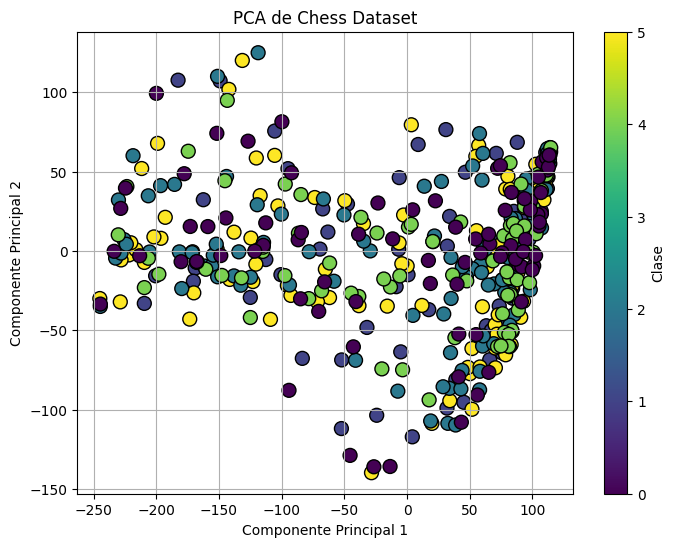

AUC-ROC para la clase 'Bishop': 0.45
AUC-ROC para la clase 'King': 0.65
AUC-ROC para la clase 'Knight': 0.75
AUC-ROC para la clase 'Pawn': 0.40
AUC-ROC para la clase 'Queen': 0.48
AUC-ROC para la clase 'Rook': 0.59


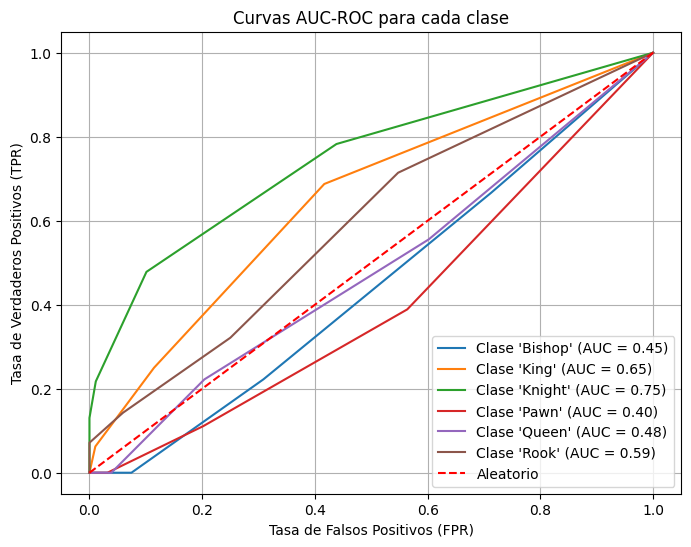

In [7]:
# 7. Evaluar el modelo
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

n_components = 50  # Número de componentes principales
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

k = 5 # Número de vecinos
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_pca, y_train)
y_probs = knn.predict_proba(X_test_pca)
y_pred = knn.predict(X_test_pca)

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision en el conjunto de prueba: {precision:.4f}')
print(f'Recall en el conjunto de prueba: {recall:.4f}')
print(f'F1-Score en el conjunto de prueba: {f1:.4f}')

# Mostrar la varianza explicada por cada componente principal
print(f"Varianza explicada por cada componente: {pca.explained_variance_ratio_}")
print(f"Varianza total explicada por los 2 componentes: {np.sum(pca.explained_variance_ratio_):.4f}")
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=labels_encoded[:444], cmap='viridis', edgecolor='k', s=100)
plt.colorbar(label='Clase')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA de Chess Dataset')
plt.grid(True)
plt.show()
labels_binarized = label_binarize(labels_encoded, classes=np.arange(len(label_encoder.classes_)))
X_train, X_test, y_train, y_test = train_test_split(images, labels_binarized, test_size=0.2, random_state=42)

n_components = 50  # Número de componentes principales
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

k = 5 # Número de vecinos
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_pca, y_train)
y_probs = knn.predict_proba(X_test_pca)
y_probs = np.array([probs[:, 1] for probs in y_probs]).T

auc_scores = []
for i, class_name in enumerate(label_encoder.classes_):
    auc = roc_auc_score(y_test[:, i], y_probs[:, i])
    auc_scores.append(auc)
    print(f"AUC-ROC para la clase '{class_name}': {auc:.2f}")

# 9. Graficar la curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f"Clase '{class_name}' (AUC = {auc_scores[i]:.2f})")
plt.plot([0, 1], [0, 1], "r--", label="Aleatorio")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curvas AUC-ROC para cada clase")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Generar datos aumentados
augmented_images = []
augmented_labels = []

for i in range(len(X_train)):
    img = X_train[i].reshape((1, image_size[0], image_size[1], 3))  # Convertir a formato de imagen
    label = y_train[i]
    for augmented_img in datagen.flow(img, batch_size=1):
        augmented_images.append(augmented_img[0].flatten())
        augmented_labels.append(label)
        if len(augmented_images) >= 2 * len(X_train):  # Generar 5 veces más datos
            break

# Convertir a arrays numpy
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Aplicar PCA para reducir la dimensionalidad
n_components = 50
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(augmented_images)
X_test_pca = pca.transform(X_test)

# Entrenar el modelo KNN
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_pca, augmented_labels)

# Evaluar el modelo
y_pred = knn.predict(X_test_pca)
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision en el conjunto de prueba: {precision:.4f}')
print(f'Recall en el conjunto de prueba: {recall:.4f}')
print(f'F1-Score en el conjunto de prueba: {f1:.4f}')

Reporte de Clasificación:
              precision    recall  f1-score   support

      Bishop       0.21      0.44      0.28        18
        King       0.32      0.44      0.37        16
      Knight       0.30      0.39      0.34        23
        Pawn       0.33      0.17      0.22        18
       Queen       0.20      0.11      0.14         9
        Rook       0.29      0.07      0.11        28

    accuracy                           0.27       112
   macro avg       0.27      0.27      0.24       112
weighted avg       0.28      0.27      0.24       112

Accuracy: 0.2679
Precision en el conjunto de prueba: 0.2811
Recall en el conjunto de prueba: 0.2679
F1-Score en el conjunto de prueba: 0.2433


In [29]:
def load_images(data_dir, image_size, max_images_per_class=100):
    images = []
    labels = []
    for class_name in os.listdir(data_dir):  # Cada carpeta es una clase
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            count = 0
            for img_file in os.listdir(class_path):
                if count >= max_images_per_class:
                    break  # Limitar el número de imágenes por clase
                img_path = os.path.join(class_path, img_file)
                try:
                    img = load_img(img_path, target_size=image_size)  # Cargar y redimensionar
                    img_array = img_to_array(img) / 255.0  # Normalizar entre 0 y 1
                    images.append(img_array.flatten())  # Convertir a vector plano
                    labels.append(class_name)
                    count += 1
                except Exception as e:
                    print(f"Error al procesar {img_path}: {e}")
    return np.array(images), np.array(labels)

# Cargar imágenes y etiquetas
images, labels = load_images(data_dir, image_size, max_images_per_class=50)

# Codificar las etiquetas a valores numéricos
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

# Definir un modelo base de árbol de decisión
decision_tree = DecisionTreeClassifier(random_state=42)

# Definir el espacio de búsqueda para RandomizedSearchCV
param_dist = {
    "criterion": ["gini", "entropy"],
    "max_depth": randint(10, 50),  # Rango aleatorio para profundidad
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5)
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=decision_tree,
    param_distributions=param_dist,
    n_iter=20,            # Número de combinaciones aleatorias a probar
    scoring="f1_macro",   # Optimizar según F1-score macro
    cv=3,                 # Validación cruzada con 3 pliegues
    verbose=1,
    n_jobs=-1,            # Usar todos los núcleos disponibles
    random_state=42
)

# Entrenar el modelo con RandomizedSearchCV
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", random_search.best_params_)

# Evaluar el modelo en el conjunto de prueba
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calcular métricas de desempeño
precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")

print("\nMétricas de Desempeño:")
print(f"Precisión (macro): {precision:.2f}")
print(f"Recall (macro): {recall:.2f}")
print(f"F1-Score (macro): {f1:.2f}")

# Reporte de clasificación detallado
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

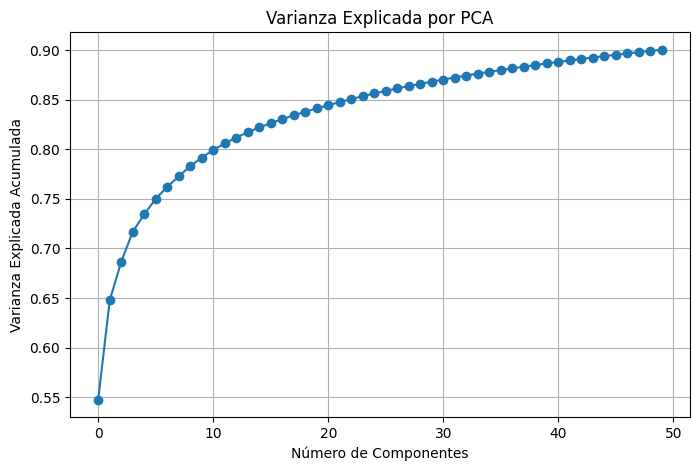

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Varianza Explicada por PCA")
plt.grid()
plt.show()

# Conclusiones
